# autoencoders

In [7]:
from torchvision import datasets, transforms, utils
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

# Create dataset

In [2]:
trns = transforms.ToTensor()

train_ds = datasets.FashionMNIST('dataset', train=True, transform=trns, download=True)
test_ds = datasets.FashionMNIST('dataset', train=False, transform=trns, download=True)

train_dataloader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_ds, batch_size=16, shuffle=True, num_workers=4)

## Display smaple image & labels

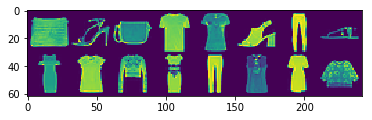

In [8]:
for i, (image, label) in enumerate(train_dataloader):
    grid = utils.make_grid(image)[0]
    plt.imshow(grid)
    break

# architecture

In [4]:
import torch.nn as nn
from torchsummary import summary

class FashionMNISTAutoencoder(nn.Module):
    
    def __init__(self):
        super(FashionMNISTAutoencoder, self).__init__()
        
        self.el1 = nn.Linear(784, 1500)
        self.el2 = nn.Linear(1500, 1000)
        self.el3 = nn.Linear(1000, 500)
        
        self.lv = nn.Sequential(nn.Linear(500, 10), nn.Sigmoid())
        
        self.dl1 = nn.Linear(10, 500)
        self.dl2 = nn.Linear(500, 1000)
        self.dl3 = nn.Linear(1000, 1500)
        
        self.ol = nn.Linear(1500, 784)
        
    def forward(self, x):
        x = x.reshape(-1, 784)
        out = F.relu(self.el1(x))
        out = F.relu(self.el2(out))
        out = F.relu(self.el3(out))
        
        out = self.lv(out)
                
        out = F.relu(self.dl1(out))
        out = F.relu(self.dl2(out))
        out = F.relu(self.dl3(out))
        
        return self.ol(out)
        
# test model
with torch.no_grad():
    x = Variable(torch.FloatTensor(np.random.random((1, 1, 28, 28))))
    print(x.shape)
    model = FashionMNISTAutoencoder()
    y = model(x)
    print(y.shape)
    
    print(model)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
    model = model.to(device)

    summary(model, (1, 28, 28))

torch.Size([1, 1, 28, 28])
torch.Size([1, 784])
FashionMNISTAutoencoder(
  (el1): Linear(in_features=784, out_features=1500, bias=True)
  (el2): Linear(in_features=1500, out_features=1000, bias=True)
  (el3): Linear(in_features=1000, out_features=500, bias=True)
  (lv): Sequential(
    (0): Linear(in_features=500, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (dl1): Linear(in_features=10, out_features=500, bias=True)
  (dl2): Linear(in_features=500, out_features=1000, bias=True)
  (dl3): Linear(in_features=1000, out_features=1500, bias=True)
  (ol): Linear(in_features=1500, out_features=784, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1500]       1,177,500
            Linear-2                 [-1, 1000]       1,501,000
            Linear-3                  [-1, 500]         500,500
            Linear-4                   [-1, 10]           5,

# Train

In [5]:
model = FashionMNISTAutoencoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = model.to(device)
    
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 1
total_step = len(train_dataloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        # labels = labels.to(device).float()
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, images.clone().reshape(16, 784))
        
        # back propogate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
        

Epoch [1/1], Step [100/3750], Loss: 0.0484
Epoch [1/1], Step [200/3750], Loss: 0.0384
Epoch [1/1], Step [300/3750], Loss: 0.0350
Epoch [1/1], Step [400/3750], Loss: 0.0402
Epoch [1/1], Step [500/3750], Loss: 0.0367
Epoch [1/1], Step [600/3750], Loss: 0.0303
Epoch [1/1], Step [700/3750], Loss: 0.0386
Epoch [1/1], Step [800/3750], Loss: 0.0281
Epoch [1/1], Step [900/3750], Loss: 0.0335
Epoch [1/1], Step [1000/3750], Loss: 0.0315
Epoch [1/1], Step [1100/3750], Loss: 0.0289
Epoch [1/1], Step [1200/3750], Loss: 0.0207
Epoch [1/1], Step [1300/3750], Loss: 0.0200
Epoch [1/1], Step [1400/3750], Loss: 0.0228
Epoch [1/1], Step [1500/3750], Loss: 0.0262
Epoch [1/1], Step [1600/3750], Loss: 0.0307
Epoch [1/1], Step [1700/3750], Loss: 0.0270
Epoch [1/1], Step [1800/3750], Loss: 0.0247
Epoch [1/1], Step [1900/3750], Loss: 0.0325
Epoch [1/1], Step [2000/3750], Loss: 0.0257
Epoch [1/1], Step [2100/3750], Loss: 0.0222
Epoch [1/1], Step [2200/3750], Loss: 0.0212
Epoch [1/1], Step [2300/3750], Loss: 0.02

# Predictions on val data

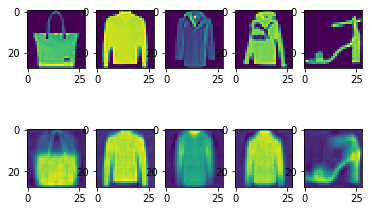

In [6]:
f, ax = plt.subplots(2, 5)

with torch.no_grad():
    i, (test_imgs, _) = next(enumerate(test_dataloader))
    for i in range(5):
        ax[0][i].imshow(test_imgs[i].reshape(28, 28))
        
    test_imgs = test_imgs.to(device)
    test_imgs_output = model(test_imgs.reshape(-1, 784))
    test_imgs_output = test_imgs_output.reshape(-1, 1, 28, 28)
    
    for i in range(5):
        ax[1][i].imshow(test_imgs_output[i].reshape(28, 28))
